# Gov Exploratory Analysis - 3nd step

### Etapa de análise exploratória dos dados;

### Author: Marcos Vinicius Ribeiro Silva

## Libraries

In [109]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from pylab import rcParams
%matplotlib inline

sns.set_theme(style="darkgrid")

## Load dataset

In [110]:
if 'new_data.csv' not in os.listdir(os.getcwd()):
    raise Exception('Run 1st step script!')

df = pd.read_csv('new_data.csv')
df.sample(10)

,CODUFMUN,TP_UNID,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ESTADO,REGIAO,CODUF,CODMUN
288018,420240,5,10,10,0,1,21,SC,SU,42,4202404
786100,314190,5,1,0,1,8,19,MG,SE,31,3141900
2292471,521380,5,10,10,0,11,22,GO,CO,52,5213806
3169364,351870,5,6,6,0,3,22,SP,SE,35,3518701
2068495,353620,5,7,7,0,6,18,SP,SE,35,3536208
2748101,350900,5,6,6,0,6,20,SP,SE,35,3509007
97159,350950,62,6,0,6,10,17,SP,SE,35,3509502
1643312,250030,5,14,14,0,3,21,PB,NE,25,2500304
1319230,310620,5,5,5,0,9,22,MG,SE,31,3106200
2339326,292100,5,5,5,0,10,21,BA,NE,29,2921005


## Create feature to time series

In [111]:
df = df.sort_values(by=["ANO", "MES"])

df["ANO_S"] = [str(x).zfill(2) for x in df['ANO']]
df["MES_S"] = [str(x).zfill(2) for x in df['MES']]
df["ANO-MES"] = df['ANO_S'] + "-" + df["MES_S"]
df = df.drop(["ANO_S", "MES_S"], axis=1)
df.head()

,CODUFMUN,TP_UNID,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ESTADO,REGIAO,CODUF,CODMUN,ANO-MES
115892,290010,5,3,3,0,1,17,BA,NE,29,2900108,17-01
115893,290010,5,1,1,0,1,17,BA,NE,29,2900108,17-01
115894,290010,5,4,4,0,1,17,BA,NE,29,2900108,17-01
115895,290010,5,2,2,0,1,17,BA,NE,29,2900108,17-01
115896,290020,5,8,8,0,1,17,BA,NE,29,2900207,17-01


## Analysis

### Número de leitos no estado de Goiás

In [112]:
df_GO = df[df.ESTADO == 'GO']
df_GO = df_GO.drop(['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO', 'ESTADO'], axis=1)
df_GO.sample(10)

,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ANO-MES
2374977,2,2,0,1,19,19-01
924549,9,9,0,8,20,20-08
1555810,20,12,8,12,17,17-12
3247986,3,0,3,10,21,21-10
2718519,8,0,8,6,18,18-06
2532241,30,30,0,6,22,22-06
2119376,4,0,4,12,20,20-12
504774,3,0,3,9,18,18-09
1809166,2,1,1,8,17,17-08
2609275,4,4,0,3,21,21-03


In [113]:
df_GO_year = df_GO.groupby('ANO').sum()

qt_exist_ant, qt_sus_ant, qt_nsus_ant = 0, 0, 0
qt_exist_dif, qt_sus_dif, qt_nsus_dif = [], [], []

for i in range(df_GO_year.shape[0]):
    row = df_GO_year.iloc[i]
    if qt_exist_ant > 0:
        qt_exist_dif.append((row.QT_EXIST - qt_exist_ant) / row.QT_EXIST * 100)
    else:
        qt_exist_dif.append(0)
    
    if qt_sus_ant > 0:
        qt_sus_dif.append((row.QT_SUS - qt_sus_ant) / row.QT_SUS * 100)
    else:
        qt_sus_dif.append(0)
        
    if qt_nsus_ant > 0:
        qt_nsus_dif.append((row.QT_NSUS - qt_nsus_ant) / row.QT_NSUS * 100)
    else:
        qt_nsus_dif.append(0)
        
    qt_sus_ant = row.QT_SUS
    qt_exist_ant = row.QT_EXIST
    qt_nsus_ant = row.QT_NSUS

df_GO_year = pd.DataFrame({'QT_EXIST': df_GO_year.QT_EXIST,
                           'QT_EXIST_%': qt_exist_dif,
                           'QT_SUS': df_GO_year.QT_SUS,
                           'QT_SUS_%': qt_sus_dif,
                           'QT_NSUS': df_GO_year.QT_NSUS,
                           'QT_NSUS_%': qt_nsus_dif})

df_GO_year.head()

,QT_EXIST,QT_EXIST_%,QT_SUS,QT_SUS_%,QT_NSUS,QT_NSUS_%
ANO,,,,,,
17,234694,0.000000,141975,0.000000,92719,0.000000
18,213896,-9.723417,128587,-10.411628,85309,-8.686071
19,228619,6.439972,138217,6.967305,90402,5.633725
20,244056,6.325188,147242,6.129365,96814,6.623009
21,268178,8.994772,161935,9.073394,106243,8.874938


### Conclusão

Em valores absolutos podemos observar o numero de leitos antes da pandemia apresentava regressão no número de leitos. Nos anos da pandemia (de 2019 a 2021) o estado manteve uma alta constante de 6% ao ano no número de leitos geral e também no numero de leitos no SUS.

         QT_EXIST  QT_SUS  QT_NSUS
ANO-MES                           
17-01       19490   12122     7368
17-02       19540   12147     7393
17-03       19593   11939     7654
17-04       19636   11865     7771
17-05       19570   11820     7750


<AxesSubplot:xlabel='ANO-MES'>

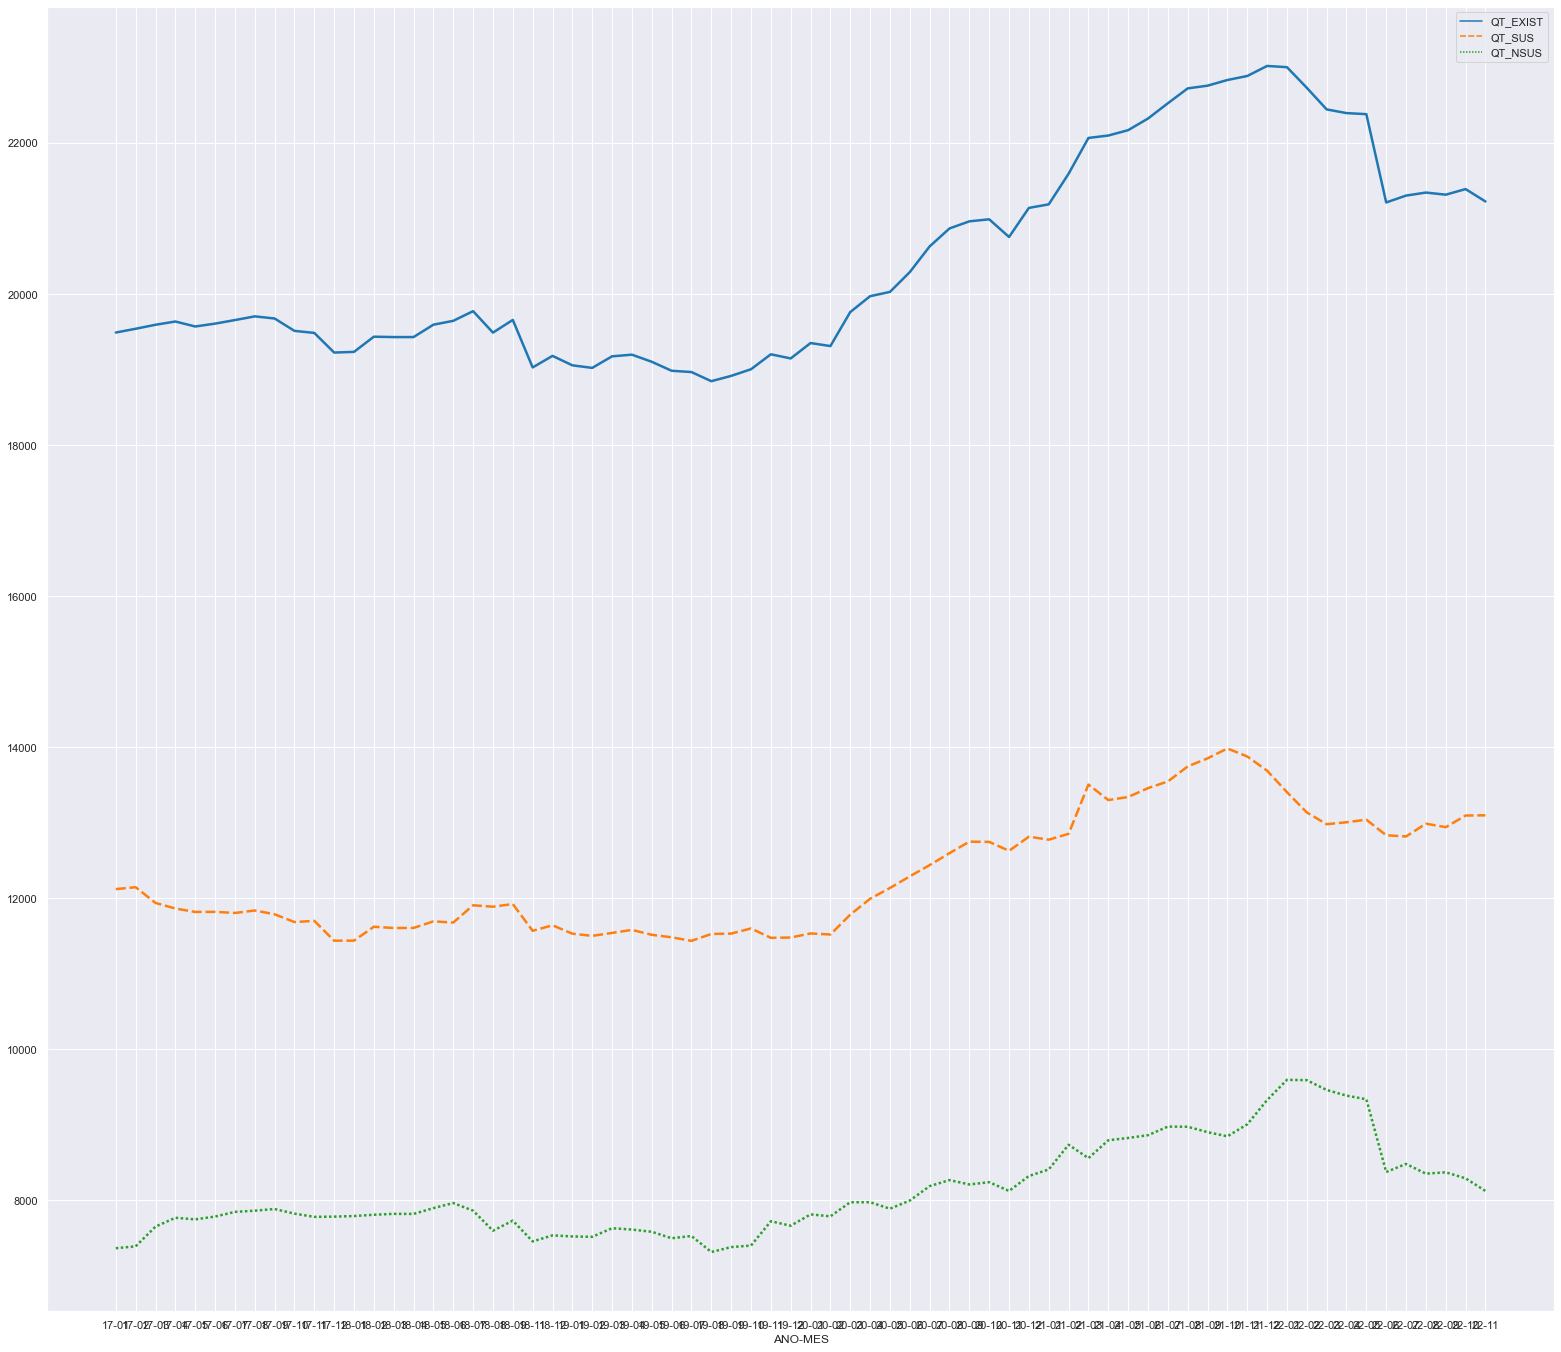

In [114]:
rcParams['figure.figsize'] = 27, 24
df_GO_graph = df_GO.drop(['ANO', 'MES'], axis=1)
df_GO_graph = df_GO_graph.groupby('ANO-MES').sum()
print(df_GO_graph.head())
sns.lineplot(data=df_GO_graph, palette="tab10", linewidth=2.5)

### Conclusão:
No gráfico acima podemos ver o números de leitos (em valores absolutos) disponíveis no estado de Goiás do começo do ano de 2017 ao final do ano de 2021. Fica claro a curva ascendente no número de leitos disponíveis no estado no período da pandemia. Ainda podemos abservar que mesmo ao final do período da pandemia (final de 2020) o número de leitos vem diminuindo mas ainda permanece muito acima do período antes da pandemia.

            QT_SUS    QT_NSUS
ANO-MES                      
17-01    21.028356 -58.255191
17-02    19.422722 -58.610544
17-03   -20.580418 -45.159656
17-04   -36.827772 -39.210536
17-05   -37.855546 -39.045587


<AxesSubplot:xlabel='ANO-MES'>

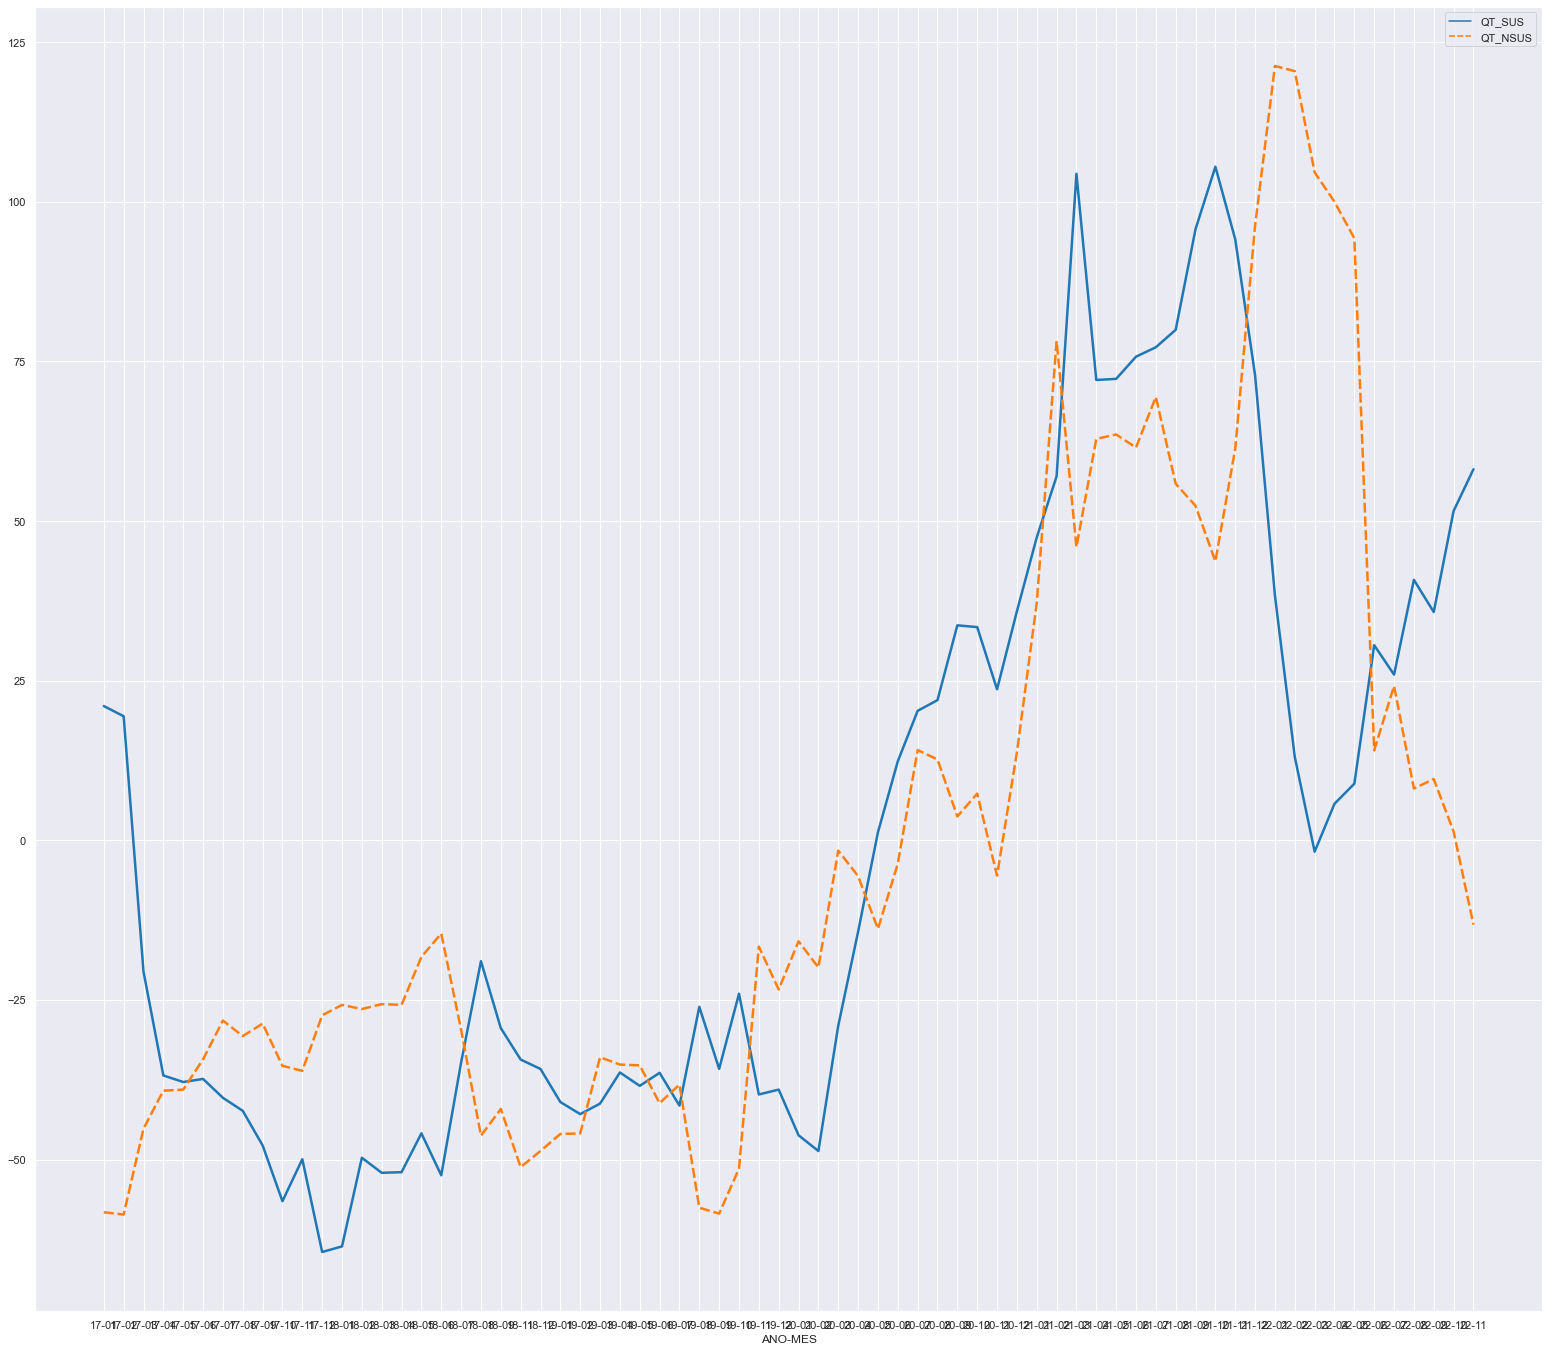

In [115]:
rcParams['figure.figsize'] = 27, 24
df_GO_graph = df_GO.drop(['ANO', 'MES', 'QT_EXIST'], axis=1)

# normalize
min_max_scaler = preprocessing.MinMaxScaler() # normalize method
for column in ['QT_SUS', 'QT_NSUS']:
    x = df_GO_graph[column].values
    x_scaled = normalize([x], norm="l1")
    df_GO_graph[column] = x_scaled[0]

df_GO_scaled = df_GO_scaled.groupby('ANO-MES').sum()
print(df_GO_scaled.head())
sns.lineplot(data=df_GO_scaled, palette="tab10", linewidth=2.5)

### Conclusão
No gráfico acima podemos comparar o número de leitos (em valores normalizados) disponibilizados pelo SUS em comparação aos leitos disponiblizados pelas outras redes hospitalares do estado. Podemos concluir com este gráfico que o SUS teve um desempenho compatível com as redes de leitos privadas e conveniadas do estado de Goiás no quesito disponibilização de leitos no período da pandemia.

### Número de leitos no estado de Goiás comparados com o Centro-Oeste

In [116]:
df_CO = df[df.REGIAO == 'CO']
df_CO = df_CO.drop(['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO'], axis=1)
df_CO.sample(10)

,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ESTADO,ANO-MES
2955712,1,1,0,11,18,GO,18-11
2779030,1,0,1,2,21,GO,21-02
1191764,37,30,7,3,18,MT,18-03
2252235,2,2,0,7,20,GO,20-07
3019443,2,0,2,1,21,GO,21-01
2045567,3,3,0,9,17,GO,17-09
1268743,4,4,0,5,17,MS,17-05
2017537,6,6,0,12,19,GO,19-12
1576485,9,9,0,10,19,GO,19-10
1144620,3,0,3,3,21,MT,21-03


<AxesSubplot:xlabel='ANO-MES', ylabel='QT_EXIST'>

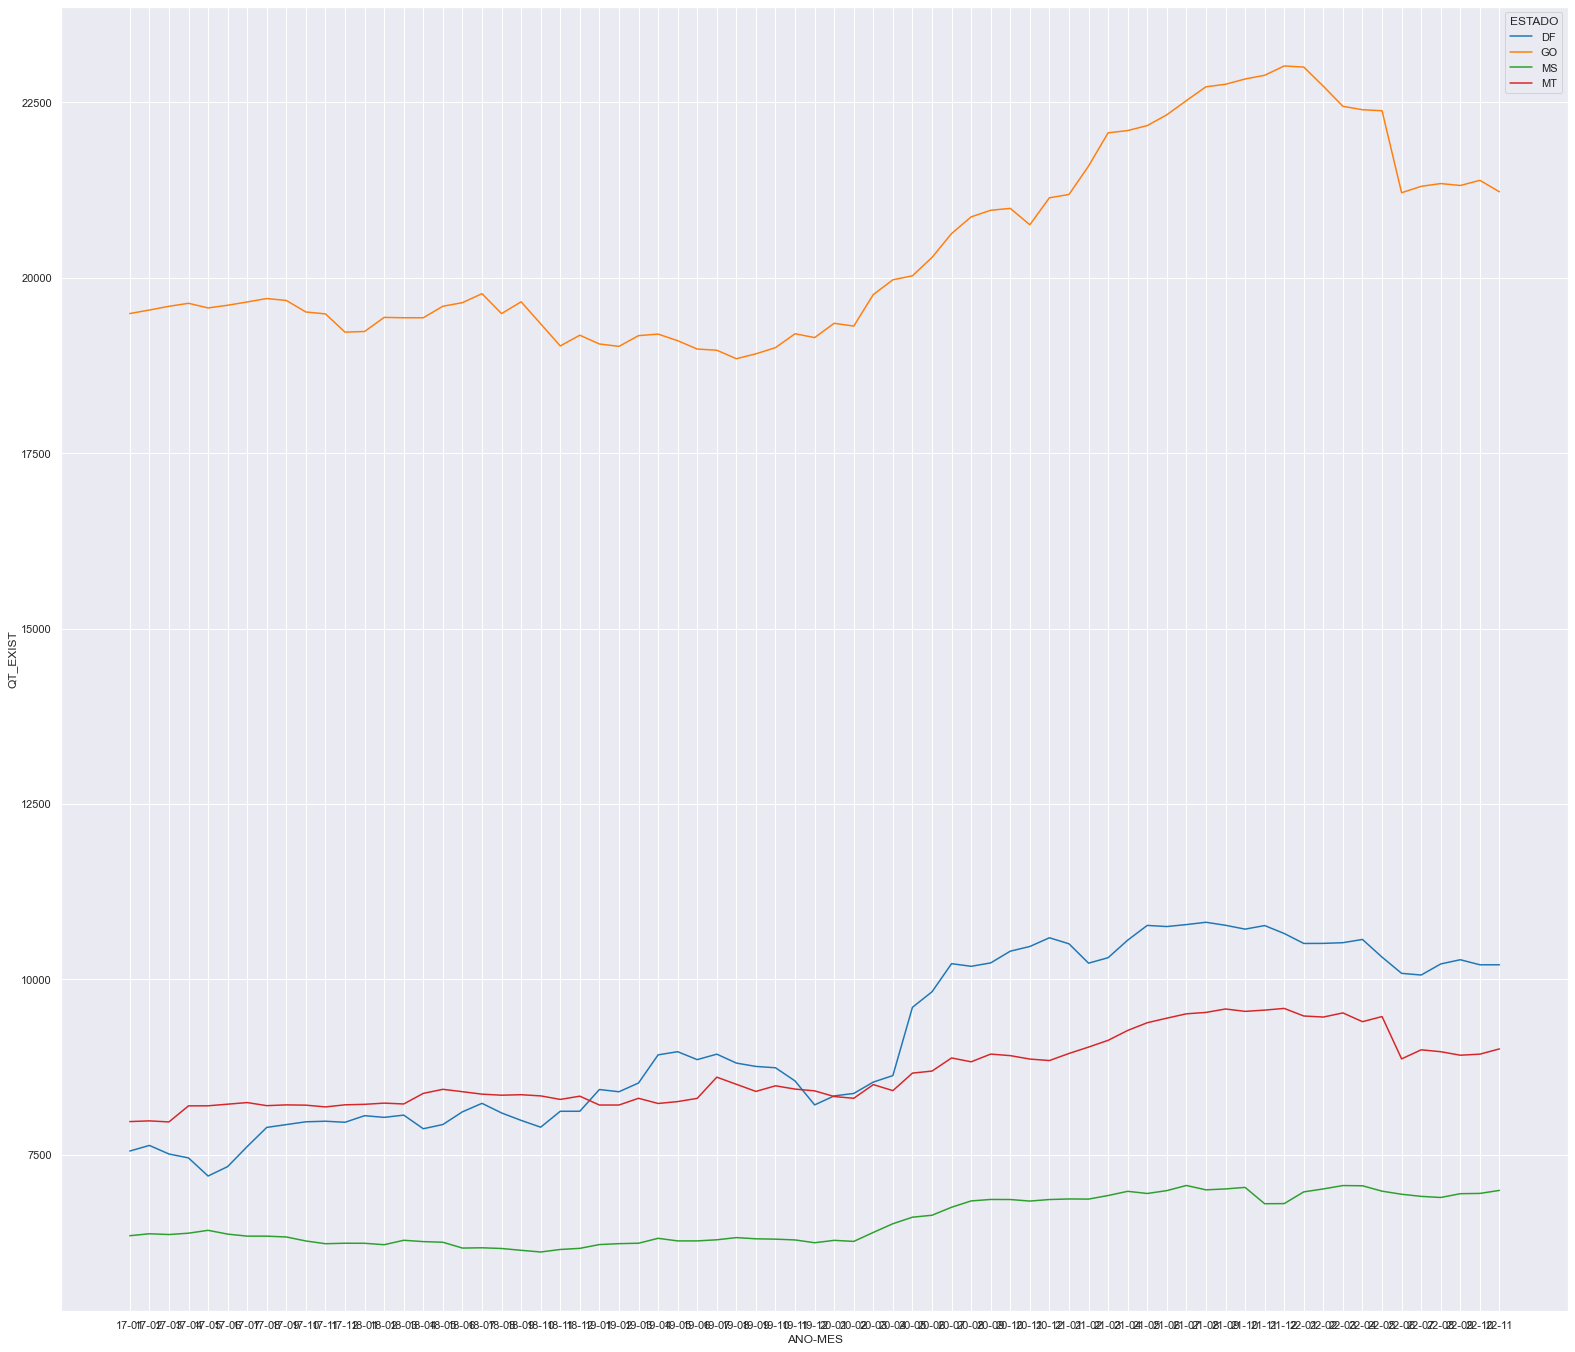

In [117]:
rcParams['figure.figsize'] = 27, 24
df_CO = df[df.REGIAO == 'CO']


list_drop = ['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO', 
             'ANO', 'MES', 'QT_SUS', 'QT_NSUS']

df_CO = df_CO.drop(list_drop, axis=1)
df_CO = df_CO.groupby(by=['ANO-MES', 'ESTADO'], as_index=False).sum()

sns.lineplot(data=df_CO, x='ANO-MES', y='QT_EXIST', hue='ESTADO', palette="tab10")

## Conclusão:

Neste gráfico podemos observar a quantidade de leitos no estado de Goiás em comparação aos outros estados do Centro-Oeste. Mesmo tendo área quadrada próxima aos outros estados podemos ver que estado de Goiás tem muito mais leitos disponíveis na região e que ainda, podemos percerber que a curva de disponibilização de leitos na região é mais progressiva e mais consistente que os outros estados.

ANO-MES     17-09
ESTADO         GO
QT_EXIST    19676
Name: 32, dtype: object
ANO-MES     17-09
ESTADO         MS
QT_EXIST     6327
Name: 33, dtype: object
ANO-MES     17-09
ESTADO         MT
QT_EXIST     8210
Name: 34, dtype: object


<AxesSubplot:xlabel='ANO-MES', ylabel='QT_EXIST'>

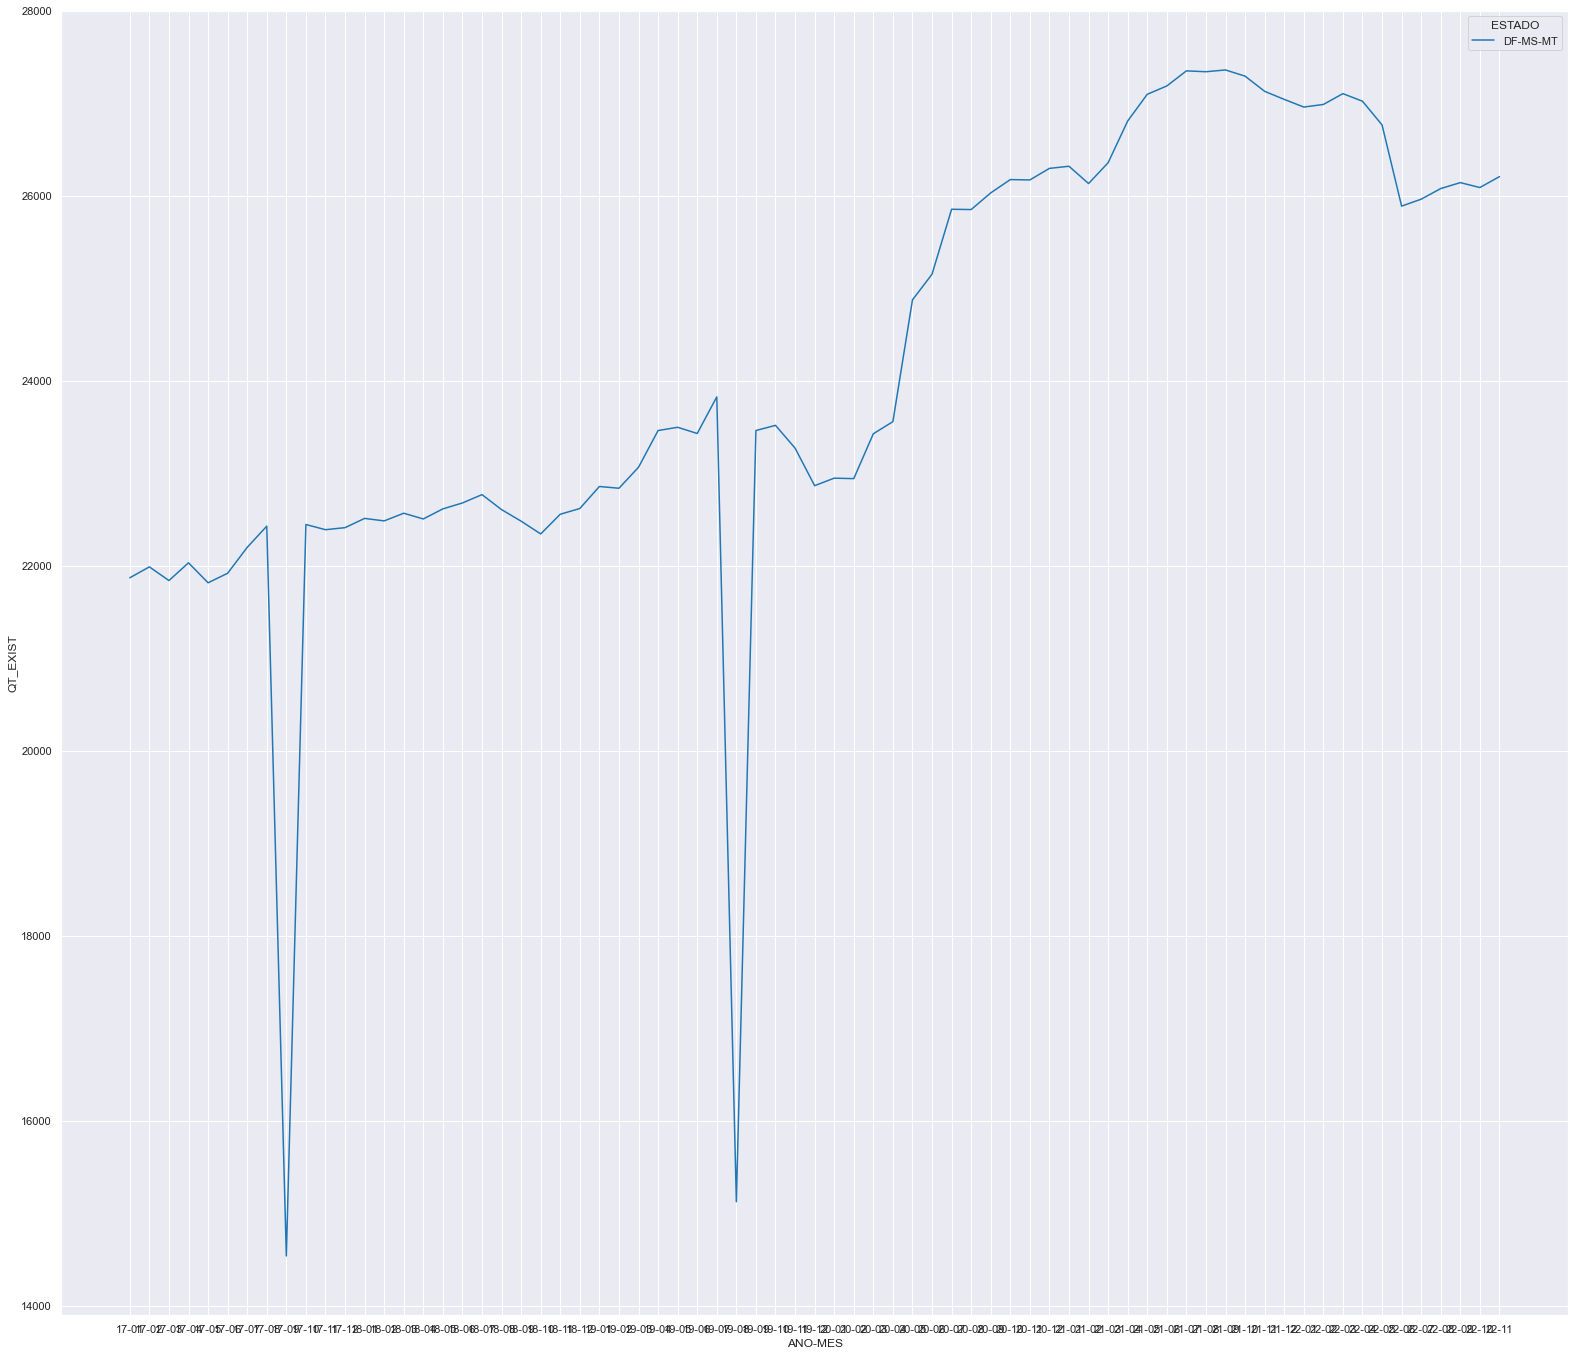

In [143]:
rcParams['figure.figsize'] = 27, 24
df_CO = df[df.REGIAO == 'CO']


list_drop = ['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO', 
             'ANO', 'MES', 'QT_SUS', 'QT_NSUS']

df_CO = df_CO.drop(list_drop, axis=1)
df_CO = df_CO.groupby(by=['ANO-MES', 'ESTADO'], as_index=False).sum()

df_CO = df_CO[df_CO['ANO-MES'] == '17-09'] #  '19-08'
for i in range(df_CO.shape[0]):
    print(df_CO.iloc[i])

# df_AUX = df_CO[df_CO.ESTADO != 'GO']
# df_AUX = df_AUX.groupby(by=['ANO-MES'], as_index=False).sum()
# df_AUX['ESTADO'] = 'DF-MS-MT'

# df_AUX2 = df_AUX[df_AUX['QT_EXIST'] < 16000]
# for i in range(df_AUX2.shape[0]):
#     print(df_AUX2.iloc[i])

# df_CO = df_CO[df_CO.ESTADO == 'GO']
# df_CO = df_CO.append(df_AUX, ignore_index=True)
# df_CO = df_CO.sort_values(by=["ANO-MES", 'ESTADO'])
# print(df_CO.head())

# min_max_scaler = preprocessing.MinMaxScaler() # normalize method
# for column in ['QT_EXIST']:
#     x = df_CO[column].values
#     x_scaled = normalize([x], norm="l1")
#     df_CO[column] = x_scaled[0]

sns.lineplot(data=df_AUX, x='ANO-MES', y='QT_EXIST', hue='ESTADO', palette="tab10")